# Stellar variability with Kepler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import glob
import sklearn
import random
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from google.colab import drive

In [ ]:
#path della mia directory
drive.mount('/content/drive', force_remount=True)
# directory = '/Users/mato/Desktop/uni/deep_learning/Kepler/'
directory = '/content/drive/My Drive/Kepler/'

#Faccio scorrere tutte le sottocartelle e prendo tutti i path di ongni file
filepaths = glob.glob(directory + "/*/*.png")
#Estraggo le etichette dal path
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

#Faccio il dataframe
filepaths_series = pd.Series(filepaths, name='Filepaths').astype(str)
labels_series = pd.Series(labels, name='Labels')
images_paths = pd.concat([filepaths_series, labels_series], axis=1)
images_paths = images_paths.sample(frac=1).reset_index(drop=True)
#Ho rimescolato le immagini con sample(frac=1) e ho risettato gli indici

MessageError: Error: credential propagation was unsuccessful

In [ ]:
images_paths

,Filepaths,Labels
0,/content/drive/My Drive/Kepler/Exoplanets/Kepl...,Exoplanets
1,/content/drive/My Drive/Kepler/Binary stars/75...,Binary stars
2,/content/drive/My Drive/Kepler/Normal stars/97...,Normal stars
3,/content/drive/My Drive/Kepler/Exoplanets/Kepl...,Exoplanets
4,/content/drive/My Drive/Kepler/Exoplanets/Kepl...,Exoplanets
...,...,...
2004,/content/drive/My Drive/Kepler/Exoplanets/Kepl...,Exoplanets
2005,/content/drive/My Drive/Kepler/Variable stars ...,Variable stars
2006,/content/drive/My Drive/Kepler/Exoplanets/Kepl...,Exoplanets
2007,/content/drive/My Drive/Kepler/Normal stars/97...,Normal stars


In [ ]:
# Conto il numero di immagini per ogni classe
plt.figure(figsize = (10,10))
class_counts = images_paths["Labels"].value_counts()
#Faccio il diagramma a torta
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette("colorblind"))

plt.title("The dataset")
plt.savefig("The dataset", bbox_inches="tight", dpi = 500)
plt.show()

NameError: name 'images_paths' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
#Ho un dataset molto sbilanciato, dovrò fare class weighting

In [ ]:
#Prima separo il dataset di test
train_size = 0.75
test_size = 1 - train_size
train_paths, test_paths = sklearn.model_selection.train_test_split(images_paths, train_size=train_size,test_size=test_size)

In [ ]:
#riscalo le immagini per averle in bianco e nero
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split= 0.33)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
#Ho immagini grosse, provo a riscalarle un pochino e a renderle quadrate
train_images = train_generator.flow_from_dataframe(
    dataframe=train_paths,
    x_col='Filepaths',
    y_col='Labels',
    subset='training',
    target_size= (256, 256), # dimensione immagini
    color_mode= 'rgb',  #colore
    class_mode= 'categorical', # perchè è un problema di classificazione
    batch_size= 64, # meglio potenze di 2
    shuffle= True,
    seed= 21 # con il seed si riprodurrà sempre la stessa sequenza di numeri casuali
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_paths,
    x_col='Filepaths',
    y_col='Labels',
    subset='validation',
    target_size= (256, 256),
    color_mode= 'rgb',
    class_mode= 'categorical',
    batch_size= 64,
    shuffle= True,
    seed= 21
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_paths,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32, #posso permettermi un batch più piccolo
    shuffle=False
)

Found 1010 validated image filenames belonging to 4 classes.
Found 496 validated image filenames belonging to 4 classes.
Found 503 validated image filenames belonging to 4 classes.


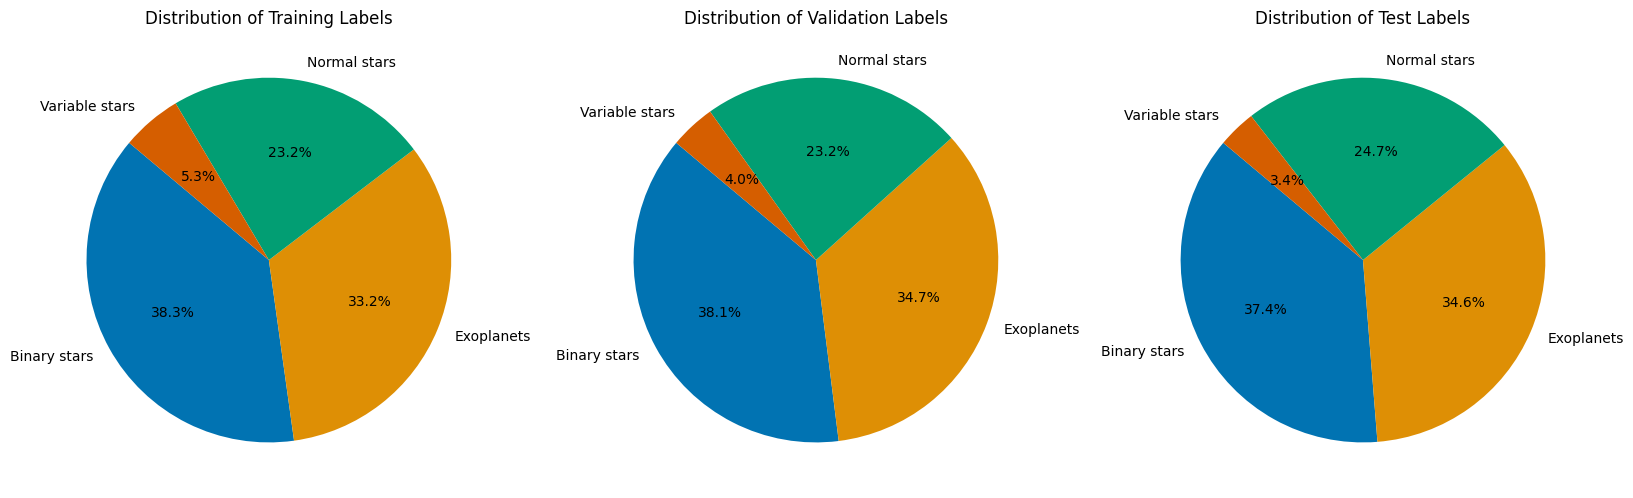

In [ ]:
train_labels = train_images.classes
train_label_names = list(train_images.class_indices.keys())
train_label_counts = pd.Series(train_labels).value_counts()

train_data = pd.DataFrame({'Labels': train_label_names, 'Count': train_label_counts.values, 'Subset': 'Train'})

plt.figure(figsize = (20,10))

plt.subplot(1,3,1)
plt.pie(train_data['Count'], labels=train_data['Labels'], autopct='%1.1f%%', startangle=140,  colors=sns.color_palette("colorblind"))
plt.title('Distribution of Training Labels')

val_labels = val_images.classes
val_label_names = list(val_images.class_indices.keys())
val_label_counts = pd.Series(val_labels).value_counts()

val_data = pd.DataFrame({'Labels': val_label_names, 'Count': val_label_counts.values, 'Subset': 'Val'})

plt.subplot(1,3,2)
plt.pie(val_data['Count'], labels=val_data['Labels'], autopct='%1.1f%%', startangle=140,  colors=sns.color_palette("colorblind"))
plt.title('Distribution of Validation Labels')

test_labels = test_images.classes
test_label_names = list(test_images.class_indices.keys())
test_label_counts = pd.Series(test_labels).value_counts()

test_data = pd.DataFrame({'Labels': test_label_names, 'Count': test_label_counts.values, 'Subset': 'Train'})
plt.subplot(1,3,3)
plt.pie(test_data['Count'], labels=test_data['Labels'], autopct='%1.1f%%', startangle=140,  colors=sns.color_palette("colorblind"))
plt.title('Distribution of Test Labels')

plt.savefig("dataset_division", dpi = 500)

Partiamo con una CNN semplice:
1. Strato per la convoluzione con: numero di filtri n filters, ognuno di essi ha dimensioni (receptive field, receptive field),
opzione padding = ”same” per mantenere la dimensione delle immagini, funzione di attivazione relu e regolarizzazione
con ridge con parametro di regolarizzazione λ.
2. Strato con funzione di attivazione maxpooling con size del pooling (2,2)
3. Strato di flatten
4. Strato densamente connesso con funzione di attivazione relu
5. Strato finale di output con n categories (10), funzione di attivazione softmax

In [ ]:
def CreateCNN(lmbd = 0.0, eta = 0.001, class_weights=class_weights):
    input_shape = (256, 256, 3)
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(n_filters1, (receptive_field1, receptive_field1), input_shape=input_shape, padding='same',
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(n_filters2, (receptive_field2, receptive_field2), padding='same',
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(n_filters3, (receptive_field3, receptive_field3), padding='same',
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_neurons_connected, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))
    model.add(tf.keras.layers.Dense(n_categories, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(lmbd)))

    loss_fn = weighted_categorical_crossentropy(class_weights)

    sgd = tf.keras.optimizers.SGD(learning_rate=eta)
    model.compile(loss=loss_fn, optimizer=sgd, metrics=['accuracy'])

    return model

Per prima cosa vogliamo fissare gli iperparametri η e λ, che sono rispettivamente il tasso di apprendimento per la discesa
stocastica del gradiente e il parametro per la regolarizzazione di Ridge. Facciamo un random search.

In [ ]:
train_labels = train_images.classes  # Estraggo le etichette numeriche
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

In [ ]:
print(class_weights)

[1.07905983 0.65245478 0.75373134 4.67592593]


In [ ]:
class_weights = tf.constant([0.82507508, 0.69733503, 0.8506192,  5.60714286], dtype=tf.float32)

In [ ]:
def weighted_categorical_crossentropy(class_weights):
    """ Funzione di perdita per cross-entropy ponderata. """

    def loss_fn(y_true, y_pred):
        # Calcola la cross-entropy
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Pondera con class_weights
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weights * ce_loss

        return tf.reduce_mean(weighted_loss)

    return loss_fn

In [ ]:
epochs = 5
batch_size = 64
input_shape = (256,256)
receptive_field1 = 3
receptive_field2 = 5
receptive_field3 = 5
n_filters1 = 24
n_filters2 = 32
n_filters3 = 32
n_neurons_connected = 64
n_categories = 4

In [ ]:
space = {
    'eta': hp.loguniform('eta', np.log(1e-4), np.log(1e-1)),
    'lmbd': hp.loguniform('lmbd', np.log(1e-4), np.log(1e-1))
}

def objective(params):
    eta = params['eta']
    lmbd = params['lmbd']

    print(f"Trying eta={eta:.5f}, lambda={lmbd:.5f}")

    model = CreateCNN(lmbd=lmbd, eta=eta, class_weights=class_weights)
    model.fit(train_images, epochs=epochs, batch_size=batch_size, validation_data=val_images, verbose=1)

    val_loss, val_accuracy = model.evaluate(val_images, verbose=0)
    print(f"Validation accuracy: {val_accuracy:.3f}\n")

    # Return a dict required by hyperopt
    return {'loss': -val_accuracy, 'status': STATUS_OK, 'model': model, 'params': params}

# Trials object to store all results
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

best_trial = sorted(trials.results, key=lambda x: x['loss'])[0]
best_model = best_trial['model']
best_eta = best_trial['params']['eta']
best_lmbd = best_trial['params']['lmbd']
best_acc = -best_trial['loss']

print(f"\nBest Model: eta={best_eta:.5f}, lambda={best_lmbd:.5f}, Validation Accuracy={best_acc:.3f}")

Trying eta=0.02572, lambda=0.01086
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/5

 1/16 ━━━━━━━━━━━━━━━━━━━━ 5:19 21s/step - accuracy: 0.1400 - loss: 3.8384
 2/16 ━━━━━━━━━━━━━━━━━━━━ 3:05 13s/step - accuracy: 0.1139 - loss: 3.7786
 3/16 ━━━━━━━━━━━━━━━━━━━━ 2:13 10s/step - accuracy: 0.1321 - loss: 3.7570
 4/16 ━━━━━━━━━━━━━━━━━━━━ 2:20 12s/step - accuracy: 0.1352 - loss: 3.7411
 5/16 ━━━━━━━━━━━━━━━━━━━━ 2:18 13s/step - accuracy: 0.1330 - loss: 3.7261
 6/16 ━━━━━━━━━━━━━━━━━━━━ 2:08 13s/step - accuracy: 0.1374 - loss: 3.7144
 7/16 ━━━━━━━━━━━━━━━━━━━━ 1:52 13s/step - accuracy: 0.1385 - loss: 3.7039
 8/16 ━━━━━━━━━━━━━━━━━━━━ 1:42 13s/step - accuracy: 0.1378 - loss: 3.6929
 9/16 ━━━━━━━━━━━━━━━━━━━━ 1:30 13s/step - accuracy: 0.1405 - loss: 3.6819
10/16 ━━━━━━━━━━━━━━━━━━━━ 1:17 13s/step - accuracy: 0.1440 - loss: 3.6723
11/16 ━━━━━━━━━━━━━━━━━━━━ 1:05 13s/step - accuracy: 0.1500 - loss: 3.6672
12/16 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - accuracy: 0.1540 - loss: 3.6630 
13/16 ━━━━━━━━━━━━━━━━━━━━ 40s 14s/step - accuracy: 0.1564 - loss: 3.6589
14/16 ━━━━━━━━━

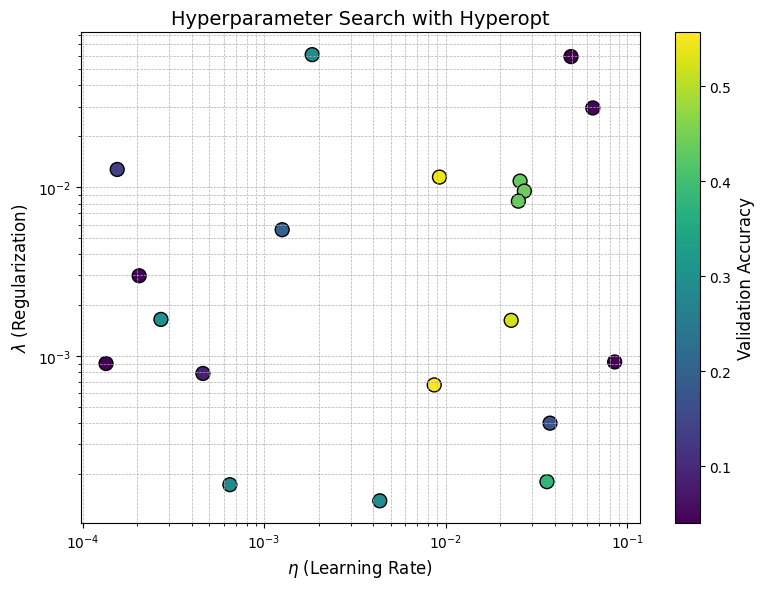

In [ ]:
eta_vals = [trial['result']['params']['eta'] for trial in trials.trials]
lmbd_vals = [trial['result']['params']['lmbd'] for trial in trials.trials]
accuracies = [-trial['result']['loss'] for trial in trials.trials]  # Negate loss to get accuracy

plt.figure(figsize=(8, 6))
scatter = plt.scatter(eta_vals, lmbd_vals, c=accuracies, cmap='viridis', s=100, edgecolors='k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\eta$ (Learning Rate)', fontsize=12)
plt.ylabel(r'$\lambda$ (Regularization)', fontsize=12)
plt.title('Hyperparameter Search with Hyperopt', fontsize=14)
plt.grid(True, which='both', linestyle="--", linewidth=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Validation Accuracy', fontsize=12)

plt.tight_layout()
plt.savefig("Hyperopt_Hyperparameters.png", bbox_inches="tight", dpi=500)
plt.show()


In [ ]:
lmbd_best = best_lmbd
eta_best = best_eta

model = CreateCNN(lmbd=lmbd_best, eta=eta_best, class_weights = class_weights)

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 256, 256, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 128, 128, 32)   │        19,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,143,012 (8.17 MB)

 Trainable params: 2,143,012 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 200


In [ ]:
# Insert an early stopping to stop the training in case the validation error increases for two consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4,restore_best_weights=True)

#Train the model and memorize in history
history = model.fit(
    train_images,
    epochs = epochs,
    validation_data = val_images,
    callbacks = callback
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2422 - loss: 1.5821 - val_accuracy: 0.2077 - val_loss: 1.4700
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2981 - loss: 1.5034 - val_accuracy: 0.2399 - val_loss: 1.4499
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3036 - loss: 1.4866 - val_accuracy: 0.2883 - val_loss: 1.4045
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3720 - loss: 1.4123 - val_accuracy: 0.3407 - val_loss: 1.3044
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4136 - loss: 1.3644 - val_accuracy: 0.5141 - val_loss: 1.2192
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4825 - loss: 1.2508 - val_accuracy: 0.4395 - val_loss: 1.4046
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4688 - loss: 1.2121 - val_accuracy: 0.6613 - val_loss: 0.9841
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6315 - loss: 0.9862 - val_accuracy: 0.6210 - v

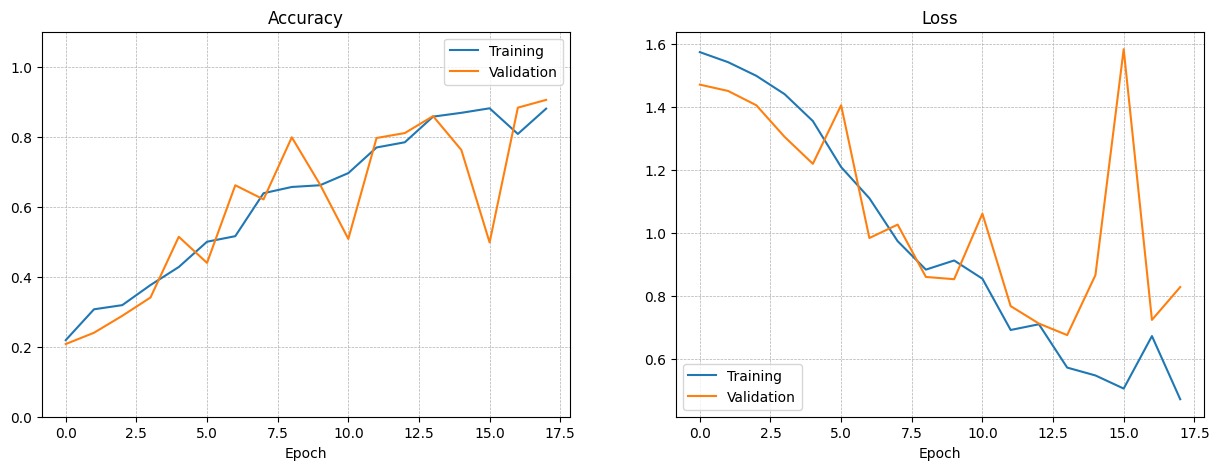

In [ ]:
#Vediamo l'andamento della funzione di costo e della accuratezza in funzione delle epoche
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,1.1)
ax[0].set_xlabel('Epoch')
ax[0].grid(linestyle = "--", linewidth = 0.5)


ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].grid(linestyle = "--", linewidth = 0.5)

#plt.savefig("Modello_piccolo_training_1", dpi = 300)
plt.show()

In [ ]:
# Performance on the test set
precisione = model.evaluate(test_images)[1]
print(f"Precision on the test set: {round(precisione*100,2)} %")

16/16 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.8577 - loss: 0.7326
Precision on the test set: 86.48 %


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step


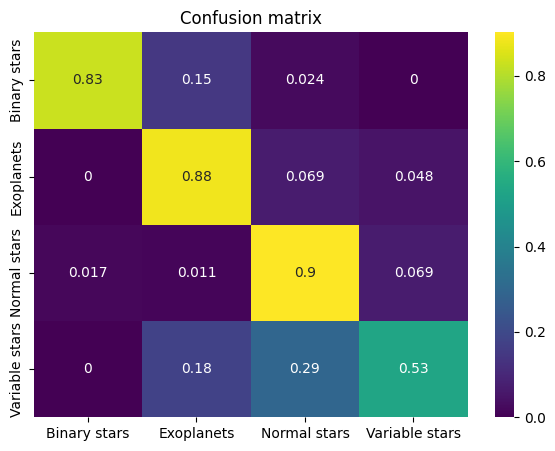

In [ ]:
#Faccio predirre al modello le etichette del dataset di test e ottengo delle probabilità per ogni classe
predictions = model.predict(test_images)
#Prendo la classe con probabilità più alta
predicted_labels = np.argmax(predictions, axis=1)
# Questo lo ho dovuto fare perchè il generatore di tensorflow indicizza le etichette internamente
class_labels = test_images.class_indices
class_labels = {v: k for k, v in class_labels.items()}
predicted_labels = [class_labels[i] for i in predicted_labels]
#Etichette vere
true_labels = test_images.classes  # Se test_images è un ImageDataGenerator
true_labels = [class_labels[i] for i in true_labels]

confusion_mat = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize = (7,5))
sns.heatmap(confusion_mat, annot=True, xticklabels = ["Binary stars", "Exoplanets", "Normal stars", "Variable stars"], yticklabels = ["Binary stars", "Exoplanets", "Normal stars", "Variable stars"], cmap = "viridis")
plt.title('Confusion matrix')
#plt.savefig("Modello_piccolo_confusion_1", dpi = 300)
plt.show()